# 1. Sequential Bayesian Learning

In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

upload = files.upload()
data = pd.read_csv("data.csv")

data = data.to_numpy()
x = data[:, :1]
t = data[:, 1:]

Saving data.csv to data.csv


## Basis function
$ \phi_j(x) = \sigma(\frac{x- \mu_j}{s}), \quad \sigma(a) = \frac{1}{1+exp(-a)}, \quad M = 3, \quad s = 0.6, \quad \mu_j = \frac{2j}{M}\quad with \quad j=0, ..., M-1 $

$ \mu_0 = 0, \quad \mu_1 = 2/3, \quad \mu_2 = 4/3$

$ \phi_0(x) = \sigma(\frac{5x}{3}), \quad \phi_1(x) = \sigma(\frac{15x-10}{9}), \quad \phi_2(x) = \sigma(\frac{15x-20}{9})$




In [2]:
def calculate_sigmoid_basis(x, order):
  basis = np.empty([x.shape[0],0])
  for i in range(order):
    y = 1 / (1 + np.exp( (10*i-15*x)/9 ))
    basis = np.concatenate( (basis, y), axis=1 )
  return basis

## Bayesian Learning
$p(w) = N(w|m_0 = 0, S_0^{-1} = 10^{-6}I), \quad \beta = 1$

$S_N^{-1} = S_0^{-1} + \beta \Phi^{T} \Phi $

$m_N = S_N(S_0^{-1}m_0 + \beta \Phi^{T} t)$

In [3]:
data_size = [0, 5, 10, 30, 80]
mN_SN_list = []

for i in range(4):
  phi = calculate_sigmoid_basis(x[data_size[i]:data_size[i+1], :], 3)
  
  if i == 0:
    m0, S0_inv = np.array([[0], [0], [0]]), 10**(-6)*np.identity(phi.shape[1])
  else:
    m0, S0_inv = mN_SN_list[i-1][0], np.linalg.inv(mN_SN_list[i-1][1])

  SN = np.linalg.inv( S0_inv + np.dot(phi.transpose(), phi) )
  mN = np.dot(SN, np.dot(S0_inv, m0) + np.dot(phi.transpose(), t[data_size[i]:data_size[i+1], :]))
  print("N = ", data_size[i+1])
  mN_SN_list.append((mN, SN))
  print("mN:\n", mN)
  print("SN:\n", SN)
  print("\n")


N =  5
mN:
 [[ 15.3918259 ]
 [-27.24893207]
 [ 13.76463907]]
SN:
 [[ 269.04934203 -577.62671303  361.07317844]
 [-577.62671303 1261.47181152 -803.66739994]
 [ 361.07317844 -803.66739994  523.15065575]]


N =  10
mN:
 [[ 15.3974152 ]
 [-27.40629378]
 [ 14.00195039]]
SN:
 [[ 168.04688541 -341.15540081  202.52975073]
 [-341.15540081  706.27405822 -429.99999167]
 [ 202.52975073 -429.99999167  270.34416277]]


N =  30
mN:
 [[ 19.22763557]
 [-35.78002777]
 [ 19.39941303]]
SN:
 [[ 24.12006368 -54.9357445   37.11498943]
 [-54.9357445  127.7793514  -88.33383235]
 [ 37.11498943 -88.33383235  62.70588466]]


N =  80
mN:
 [[ 18.85466897]
 [-34.50677874]
 [ 18.21950653]]
SN:
 [[  6.59105561 -14.94010939  10.02307411]
 [-14.94010939  34.88289614 -24.16334859]
 [ 10.02307411 -24.16334859  17.34855927]]




## 1. Plot 5 curves sampled from the parameter posterior distribution and N data points 

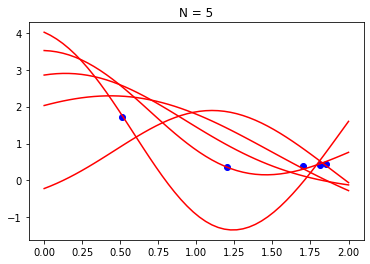

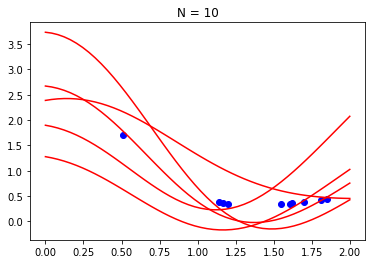

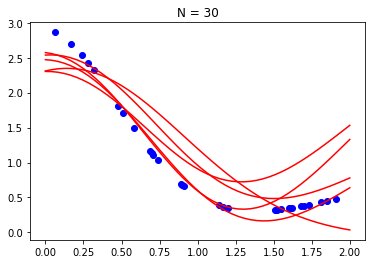

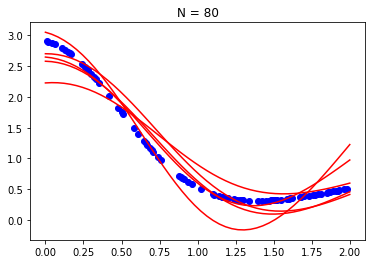

In [4]:
for i,j in enumerate(mN_SN_list):
  plt.scatter(x[:data_size[i+1]], t[:data_size[i+1]], c='blue')
  for k in range(5):
    w = np.random.multivariate_normal(j[0].reshape(j[0].shape[0]), j[1])
    #print(w)
    plotx = np.linspace(0,2)
    a = calculate_sigmoid_basis(plotx.reshape(50, 1), 3)
    ploty = np.dot(a, w.transpose())
    plt.plot(plotx, ploty, color='red')
  plt.title('N = '+str(data_size[i+1]))
  plt.show()
    


## 2. Plot the predictive distribution of target value t by showing the mean curve, the region of variance with one standard deviation on both sides of the mean curve and N data points

$p(t|\bf{x}, \bf{t}, \alpha, \beta) =$
$N(t|m^T_N\phi(x), \sigma^2_N(x))$

$\sigma^2_N(x) = \frac{1}{\beta} + \phi(x)^T S_N \phi(x)$

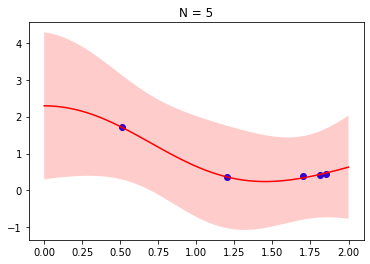

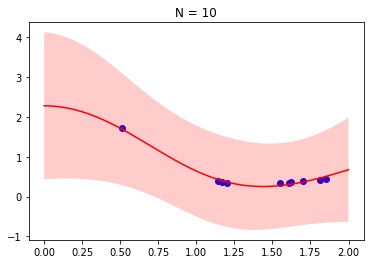

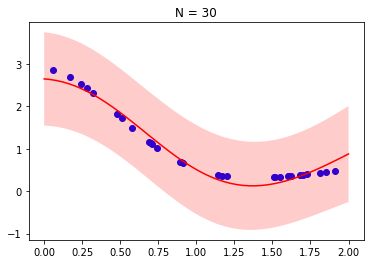

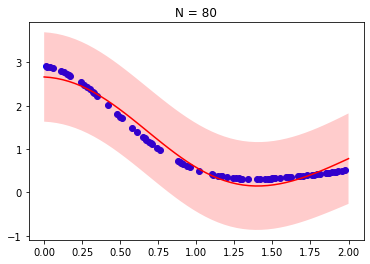

In [5]:
for i,j in enumerate(mN_SN_list):
  plt.scatter(x[:data_size[i+1]], t[:data_size[i+1]], color='blue')
  plotx = np.linspace(0,2)
  phi = calculate_sigmoid_basis(plotx.reshape(50, 1), 3)
  mean = np.dot(phi, j[0]).transpose()
  #var = np.sqrt(1+np.sum(np.dot(np.dot(phi, j[1]), phi.transpose()), axis=1))
  var = np.empty([1, 50])
  for k in range(50):
    var[0, k] = np.sqrt(1 + np.dot(np.dot(phi[k], j[1]), phi[k].transpose()))
  plt.fill_between(plotx, (mean-var).flatten(), (mean+var).flatten(), facecolor='red', alpha=0.2)
  plt.plot(plotx, mean.flatten(), color='red')
  plt.title('N = '+str(data_size[i+1]))
  plt.show()
    

## 3. Plot the prior distributions by arbitrarily selecting two weights

$N(x|\mu, \Sigma) = \frac{1}{(2\pi)^{D/2}} \frac{1}{|\Sigma|^{1/2}} exp\{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\}$

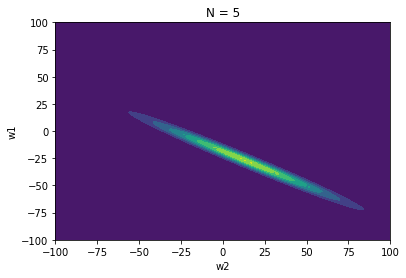

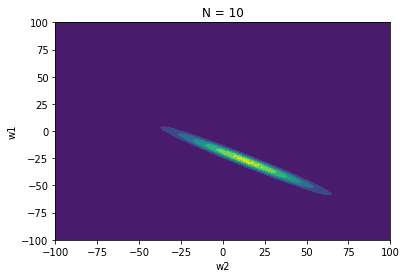

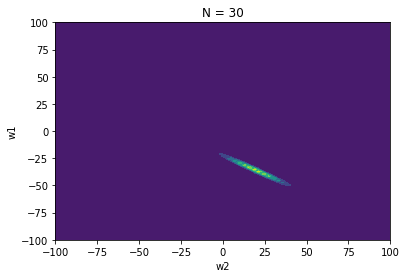

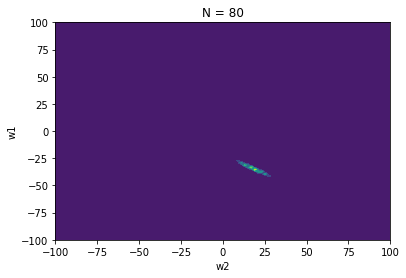

In [6]:
def multivariate_gaussian(x, mean, cov):
  # mean: 2*1
  # cov: 2*2
  mean = mean.transpose()
  prob_list = np.empty([x.shape[0], 1])
  for i in range(x.shape[0]):
    a = -1/2 * (x[i]-mean).dot(np.linalg.inv(cov)).dot((x[i]-mean).transpose())
    a = np.exp(a)
    a = 1/((2*np.pi)**2) * 1/np.sqrt(np.linalg.det(cov)) * a
    prob_list[i] = a.flatten()
  return prob_list
rand = np.random.choice(range(3), 2, replace=False)
rand_x = np.sort(rand).repeat(2)
rand_y = np.tile(rand, 2)

for i in range(4):
  plotx = np.linspace(-100, 100, 100)
  ploty = np.linspace(-100, 100, 100)
  plotx, ploty = np.meshgrid(plotx, ploty)
  plotz = np.dstack((plotx, ploty)).reshape(10000, 2)
  plotz = multivariate_gaussian(plotz, mN_SN_list[i][0][rand], mN_SN_list[i][1][1:, 1:].reshape(2, 2)).reshape(plotx.shape)
  plt.contourf(plotx, ploty, plotz)
  plt.title('N = '+str(data_size[i+1]))
  plt.xlabel("w"+str(rand[0]))
  plt.ylabel("w"+str(rand[1]))
  plt.show()


# 2. Logistic Regression


In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
import numpy as np
from google.colab import drive
from itertools import combinations_with_replacement
import matplotlib

drive.mount('/content/gdrive')

def read_img():
  data = np.empty([5, 64, 28, 28])
  for i in range(5):
    for j in range(64):
      data[i][j] = mpimg.imread('gdrive/My Drive/Fashion_MNIST/'+ str(i) +'/'+ str(j) +'.png')
      #plt.imshow(data[i][j])
  return data
data = read_img()

Mounted at /content/gdrive


## 1. Gradient descent

In [8]:
def softmax(a_nk):
  # a_nk: N*5
  # sum: N*1
  #sum = np.sum(np.exp(a_nk), axis=1).reshape(a_nk.shape[0], 1)
  #return np.exp(a_nk)/sum
  y_nk = np.empty(a_nk.shape)
  for i in range(a_nk.shape[0]):
    for j in range(a_nk.shape[1]):
      y_nk[i][j] = 1 / np.sum(np.exp(a_nk[i]-a_nk[i][j]))

  return y_nk

def cross_entropy(t, y):
  # t: N*5
  # y: N*5
  return -np.sum(t * np.log(y))

def accuracy(t, y):
  # t: N*5
  # y: N*5
  max_index = np.argmax(y, axis=1)
  count = 0
  for i in range(t.shape[0]):
    if t[i][max_index[i]] == 1:
      count += 1
  return count/t.shape[0]

def batch_GD(x, t, test_x, test_t, iter_time, learning_rate):
  # x: N*785
  # t: N*5
  train_error, train_accuracy = [], [0]
  test_error ,test_accuracy = [], [0]

  w = np.zeros([t.shape[1], x.shape[1]])
  for i in range(iter_time):
    train_x = x
    train_t = t

    train_y = softmax( np.dot(train_x, w.transpose()) ) # N*5
    test_y = softmax( np.dot(test_x, w.transpose()) )
    train_error.append(cross_entropy(train_t, train_y))
    train_accuracy.append(accuracy(train_t, train_y))
    test_error.append(cross_entropy(test_t, test_y))
    test_accuracy.append(accuracy(test_t, test_y))

    gradient = np.dot((train_y - train_t).transpose(), train_x)
    w = w - learning_rate * gradient
  #print(w)
  return [train_error, train_accuracy, test_error, test_accuracy, w]

def SGD(x, t, test_x, test_t, iter_time, learning_rate):
  # x: N*785, t: N*5
  train_error, train_accuracy = [], [0]
  test_error ,test_accuracy = [], [0]

  w = np.zeros([t.shape[1], x.shape[1]])
  for i in range(iter_time):
    per = np.random.permutation(x.shape[0])
    for j in range(x.shape[0]):
      train_x = x[j].reshape(1, x.shape[1])
      train_t = t[j].reshape(1, 5)
      train_y = softmax( np.dot(train_x, w.transpose()) ) # N*5
      gradient = np.dot((train_y - train_t).transpose(), train_x)
      w = w - learning_rate * gradient

    train_y = softmax( np.dot(train_x, w.transpose()) )
    test_y = softmax( np.dot(test_x, w.transpose()) )
    train_error.append(cross_entropy(train_t, train_y))
    train_accuracy.append(accuracy(train_t, train_y))
    test_error.append(cross_entropy(test_t, test_y))
    test_accuracy.append(accuracy(test_t, test_y))
 
  return [train_error, train_accuracy, test_error, test_accuracy, w]

def minibatch_SGD(x, t, test_x, test_t, batch_size, iter_time, learning_rate):
  # x: N*785, t: N*5
  train_error, train_accuracy = [], [0]
  test_error ,test_accuracy = [], [0]

  w = np.zeros([t.shape[1], x.shape[1]])
  for i in range(iter_time):
    per = np.random.permutation(x.shape[0])
    for j in range(int(x.shape[0]/batch_size)):
      train_x = x[per[j*batch_size:(j+1)*batch_size], :]
      train_t = t[per[j*batch_size:(j+1)*batch_size], :]
      train_y = softmax( np.dot(train_x, w.transpose()) ) # N*5
      gradient = np.dot((train_y - train_t).transpose(), train_x)
      w = w - learning_rate * gradient

    train_y = softmax( np.dot(train_x, w.transpose()) )
    test_y = softmax( np.dot(test_x, w.transpose()) )
    train_error.append(cross_entropy(train_t, train_y))
    train_accuracy.append(accuracy(train_t, train_y))
    test_error.append(cross_entropy(test_t, test_y))
    test_accuracy.append(accuracy(test_t, test_y))

  return [train_error, train_accuracy, test_error, test_accuracy, w]

In [9]:
def hessian(x, y):
  # x: N*785, y: N*5
  H = np.empty([y.shape[1], y.shape[1], x.shape[1], x.shape[1]])
  for j in range(y.shape[1]):
    for k in range(y.shape[1]):
      if j == k:
        i = 1
      else:
        i = 0
      a = (y[:, k]*(i - y[:, j])).reshape(y.shape[0], 1)
      H[j][k] = np.dot(x.transpose(), a*x)
  return H

def newton_raphson(x, t, test_x, test_t, iter_time, learning_rate):
  # x: N*785, t: N*5
  train_error = []
  train_accuracy = [0]
  test_error = []
  test_accuracy = [0]

  w = np.zeros([t.shape[1], x.shape[1]])
  for i in range(iter_time):
    train_x = x
    train_t = t

    train_y = softmax( np.dot(train_x, w.transpose()) ) # N*5
    test_y = softmax( np.dot(test_x, w.transpose()) )
    train_error.append(cross_entropy(train_t, train_y))
    train_accuracy.append(accuracy(train_t, train_y))
    test_error.append(cross_entropy(test_t, test_y))
    test_accuracy.append(accuracy(test_t, test_y))

    gradient = np.dot((train_y - train_t).transpose(), train_x)
    H = hessian(train_x, train_y)
    Hinv = np.linalg.pinv(H)
    w = w - np.tensordot(Hinv, gradient, axes=([1, 3], [0, 1])) * learning_rate
  #print(w)
  return [train_error, train_accuracy, test_error, test_accuracy, w]


In [10]:
x = np.empty([5*32, 784])
test_x = np.empty([5*32, 784])

rand = np.random.choice(range(64), 32, replace=False)
rand_test = np.delete(range(64), rand)

for i in range(5):
  for j in range(32):
    x[i*32+j] = data[i][rand[j]].flatten()
    test_x[i*32+j] = data[i][rand_test[j]].flatten()
#x = np.concatenate((np.ones([5*64, 1]), x), axis=1)

t = np.empty([0, 5])
for i in range(5):
  tmp = np.array([0, 0, 0, 0, 0])
  tmp[i] = 1
  tmp = np.tile(tmp, (32, 1))
  t = np.concatenate((t, tmp), axis=0)
test_t = t

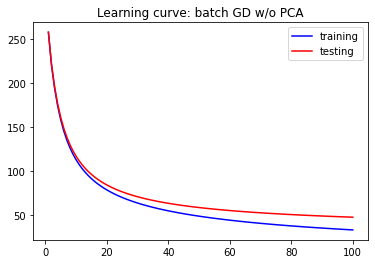

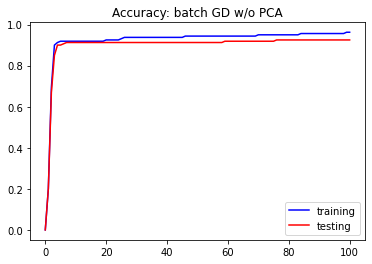

TYPE: batch GD
w/o PCA
training accuracy	:  0.9625
testing accuracy	:  0.925


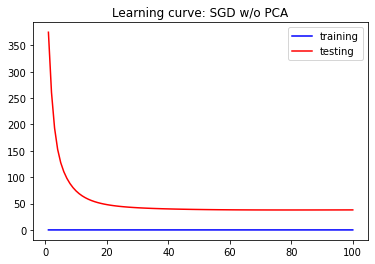

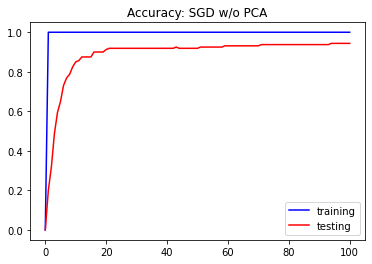

TYPE: SGD
w/o PCA
training accuracy	:  1.0
testing accuracy	:  0.94375


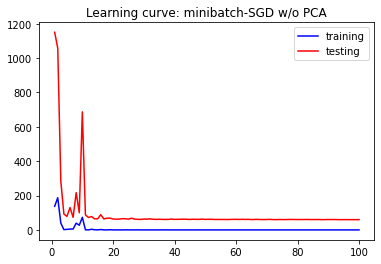

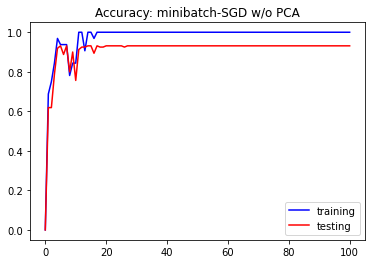

TYPE: minibatch-SGD
w/o PCA
training accuracy	:  1.0
testing accuracy	:  0.93125


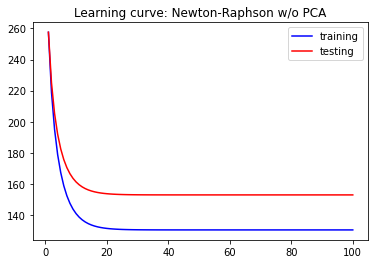

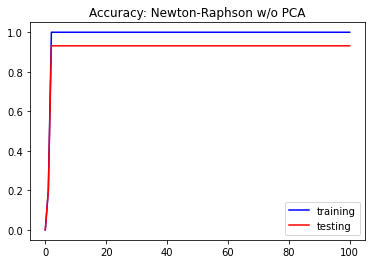

TYPE: Newton-Raphson
w/o PCA
training accuracy	:  1.0
testing accuracy	:  0.93125


In [11]:
result = batch_GD(x, t, test_x, test_t, 100, 0.0003)
plt.plot(range(1,101), result[0], '-b', label='training')
plt.plot(range(1,101), result[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: batch GD w/o PCA')
plt.show()

plt.plot(range(0,101), result[1], '-b', label='training')
plt.plot(range(0,101), result[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: batch GD w/o PCA')
plt.show()

print("TYPE: batch GD")
print("w/o PCA")
print("training accuracy\t: ", result[1][100])
print("testing accuracy\t: ", result[3][100])


result1 = SGD(x, t, test_x, test_t, 100, 0.01)
plt.plot(range(1,101), result1[0], '-b', label='training')
plt.plot(range(1,101), result1[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: SGD w/o PCA')
plt.show()

plt.plot(range(0,101), result1[1], '-b', label='training')
plt.plot(range(0,101), result1[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: SGD w/o PCA')
plt.show()

print("TYPE: SGD")
print("w/o PCA")
print("training accuracy\t: ", result1[1][100])
print("testing accuracy\t: ", result1[3][100])


result2 = minibatch_SGD(x, t, test_x, test_t, 32, 100, 0.02)
plt.plot(range(1,101), result2[0], '-b', label='training')
plt.plot(range(1,101), result2[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: minibatch-SGD w/o PCA')
plt.show()

plt.plot(range(0,101), result2[1], '-b', label='training')
plt.plot(range(0,101), result2[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: minibatch-SGD w/o PCA')
plt.show()

print("TYPE: minibatch-SGD")
print("w/o PCA")
print("training accuracy\t: ", result2[1][100])
print("testing accuracy\t: ", result2[3][100])


result3 = newton_raphson(x, t, test_x, test_t, 100, 0.01)
plt.plot(range(1,101), result3[0], '-b', label='training')
plt.plot(range(1,101), result3[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: Newton-Raphson w/o PCA')
plt.show()

plt.plot(range(0,101), result3[1], '-b', label='training')
plt.plot(range(0,101), result3[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: Newton-Raphson w/o PCA')
plt.show()

print("TYPE: Newton-Raphson")
print("w/o PCA")
print("training accuracy\t: ", result3[1][100])
print("testing accuracy\t: ", result3[3][100])

## 2. Principal component analysis (PCA)

In [12]:
def PCA(x, d):
  mean = np.mean(x, axis=0)
  x = x - mean
  s = np.dot(x.transpose(), x) / x.shape[0]
  eig_val, eig_vec = np.linalg.eig(s)
  eig_vec = eig_vec.real
  #top_d = np.argsort(-np.abs(eig_val))[:d]
  top_d = np.argsort(-eig_val)[:d]
  return eig_vec[:, top_d], np.dot(x, eig_vec[:,top_d])

def PCA_show_eigen_vec(eig_vec, d):
  for i in range(d):
    #img = eig_vec[1:, i].reshape(28, 28)
    img = eig_vec[:, i].reshape(28, 28)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.show()

### d = 2

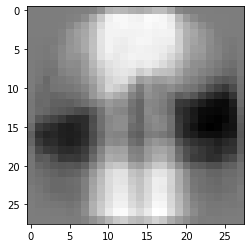

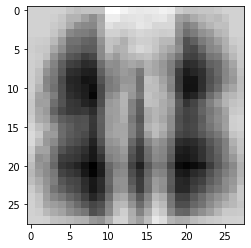

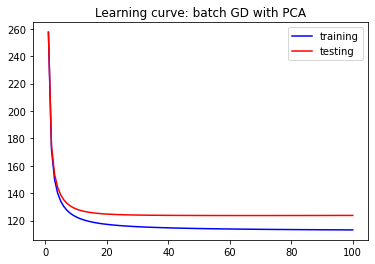

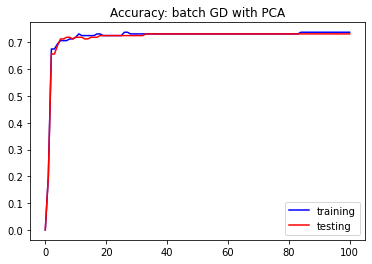

TYPE: batch GD
with PCA, d = 2
training accuracy	:  0.7375
testing accuracy	:  0.73125


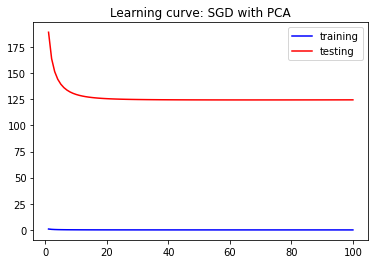

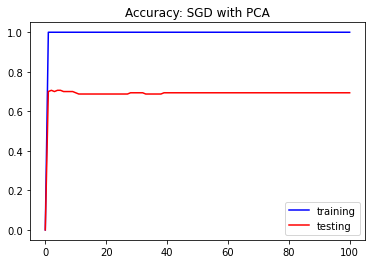

TYPE: SGD
with PCA, d = 2
training accuracy	:  1.0
testing accuracy	:  0.69375


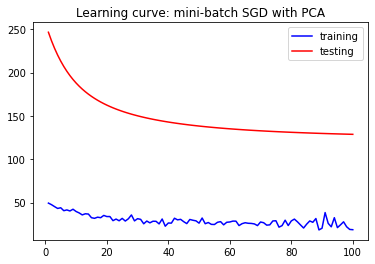

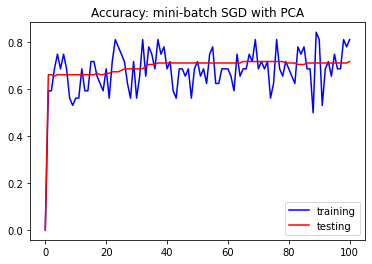

TYPE: mini-batch SGD
with PCA, d = 2
training accuracy	:  0.8125
testing accuracy	:  0.71875


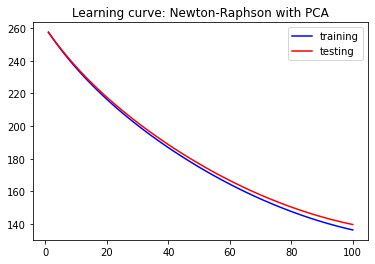

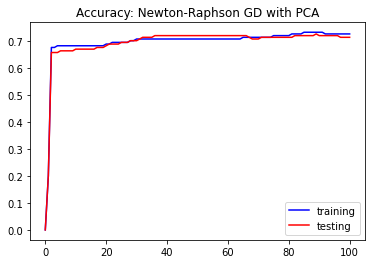

TYPE: Newton-Raphson GD
with PCA, d = 2
training accuracy	:  0.725
testing accuracy	:  0.7125


In [13]:
eig, pca_x = PCA(x, 2)
test_mean = np.mean(test_x, axis=0)
test_x = test_x - test_mean
pca_testx = np.dot(test_x, eig)
PCA_show_eigen_vec(eig, 2)

ans = batch_GD(pca_x, t, pca_testx, test_t, 100, 0.001)
plt.plot(range(1,101), ans[0], '-b', label='training')
plt.plot(range(1,101), ans[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: batch GD with PCA')
plt.show()

plt.plot(range(0,101), ans[1], '-b', label='training')
plt.plot(range(0,101), ans[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: batch GD with PCA')
plt.show()

print("TYPE: batch GD")
print("with PCA, d = 2")
print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])

ans = SGD(pca_x, t, pca_testx, test_t, 100, 0.001)
plt.plot(range(1,101), ans[0], '-b', label='training')
plt.plot(range(1,101), ans[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: SGD with PCA')
plt.show()

plt.plot(range(0,101), ans[1], '-b', label='training')
plt.plot(range(0,101), ans[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: SGD with PCA')
plt.show()

print("TYPE: SGD")
print("with PCA, d = 2")
print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])

ans = minibatch_SGD(pca_x, t, pca_testx, test_t, 32, 100, 0.0001)
plt.plot(range(1,101), ans[0], '-b', label='training')
plt.plot(range(1,101), ans[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: mini-batch SGD with PCA')
plt.show()

plt.plot(range(0,101), ans[1], '-b', label='training')
plt.plot(range(0,101), ans[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: mini-batch SGD with PCA')
plt.show()

print("TYPE: mini-batch SGD")
print("with PCA, d = 2")
print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])


ans = newton_raphson(pca_x, t, pca_testx, test_t, 100, 0.002)
plt.plot(range(1,101), ans[0], '-b', label='training')
plt.plot(range(1,101), ans[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: Newton-Raphson with PCA')
plt.show()

plt.plot(range(0,101), ans[1], '-b', label='training')
plt.plot(range(0,101), ans[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: Newton-Raphson GD with PCA')
plt.show()

print("TYPE: Newton-Raphson GD")
print("with PCA, d = 2")
print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])

### d = 5

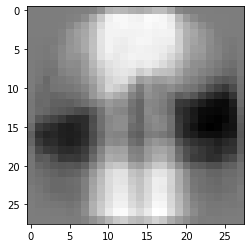

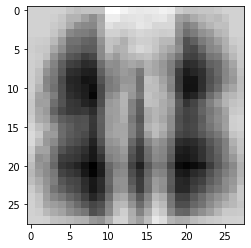

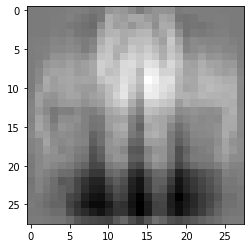

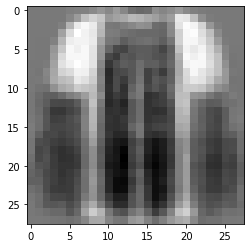

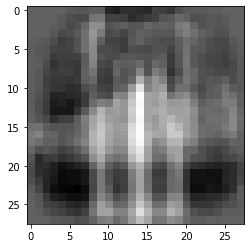

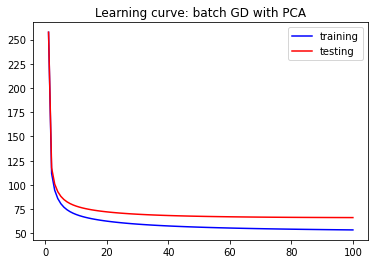

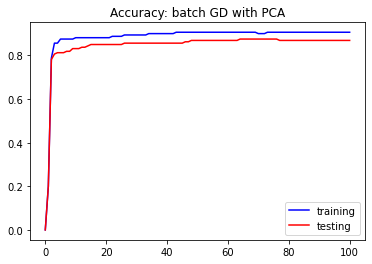

TYPE: batch GD
with PCA, d = 2
training accuracy	:  0.90625
testing accuracy	:  0.86875


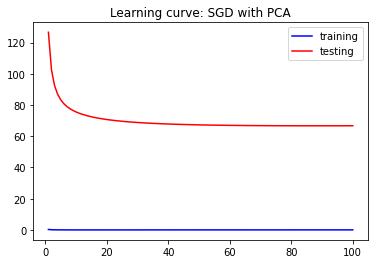

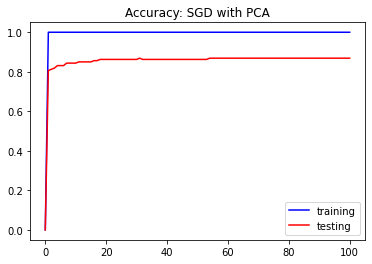

TYPE: SGD
with PCA, d = 2
training accuracy	:  1.0
testing accuracy	:  0.86875


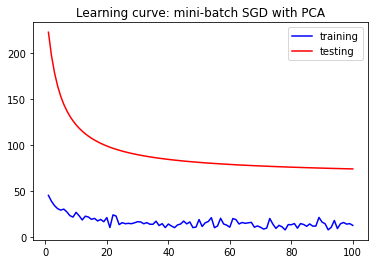

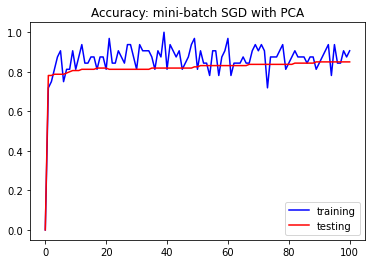

TYPE: mini-batch SGD
with PCA, d = 2
training accuracy	:  0.90625
testing accuracy	:  0.85


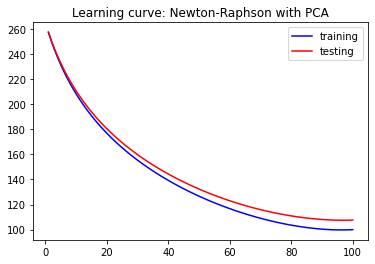

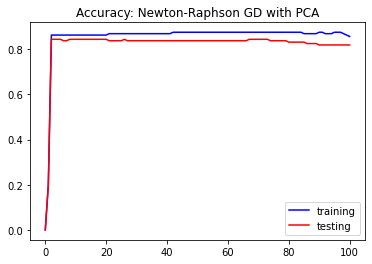

TYPE: Newton-Raphson GD
with PCA, d = 2
training accuracy	:  0.85625
testing accuracy	:  0.81875


In [14]:
eig, pca_x = PCA(x, 5)
#test_mean = np.mean(test_x, axis=0)
#test_x = test_x - test_mean
pca_testx = np.dot(test_x, eig)
PCA_show_eigen_vec(eig, 5)

ans = batch_GD(pca_x, t, pca_testx, test_t, 100, 0.002)
plt.plot(range(1,101), ans[0], '-b', label='training')
plt.plot(range(1,101), ans[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: batch GD with PCA')
plt.show()

plt.plot(range(0,101), ans[1], '-b', label='training')
plt.plot(range(0,101), ans[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: batch GD with PCA')
plt.show()

print("TYPE: batch GD")
print("with PCA, d = 2")
print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])

ans = SGD(pca_x, t, pca_testx, test_t, 100, 0.003)
plt.plot(range(1,101), ans[0], '-b', label='training')
plt.plot(range(1,101), ans[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: SGD with PCA')
plt.show()

plt.plot(range(0,101), ans[1], '-b', label='training')
plt.plot(range(0,101), ans[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: SGD with PCA')
plt.show()

print("TYPE: SGD")
print("with PCA, d = 2")
print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])

ans = minibatch_SGD(pca_x, t, pca_testx, test_t, 32, 100, 0.0003)
plt.plot(range(1,101), ans[0], '-b', label='training')
plt.plot(range(1,101), ans[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: mini-batch SGD with PCA')
plt.show()

plt.plot(range(0,101), ans[1], '-b', label='training')
plt.plot(range(0,101), ans[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: mini-batch SGD with PCA')
plt.show()

print("TYPE: mini-batch SGD")
print("with PCA, d = 2")
print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])


ans = newton_raphson(pca_x, t, pca_testx, test_t, 100, 0.003)
plt.plot(range(1,101), ans[0], '-b', label='training')
plt.plot(range(1,101), ans[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: Newton-Raphson with PCA')
plt.show()

plt.plot(range(0,101), ans[1], '-b', label='training')
plt.plot(range(0,101), ans[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: Newton-Raphson GD with PCA')
plt.show()

print("TYPE: Newton-Raphson GD")
print("with PCA, d = 2")
print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])

### d = 10

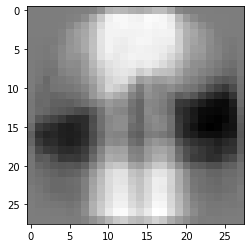

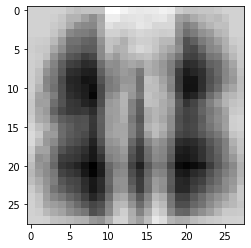

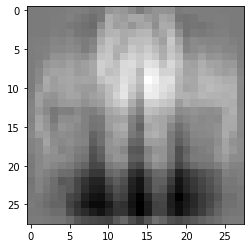

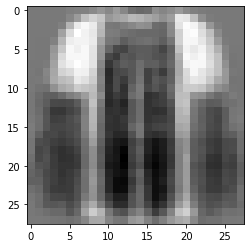

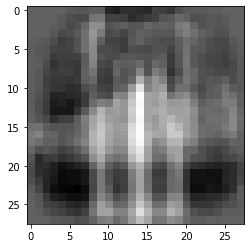

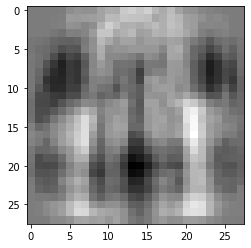

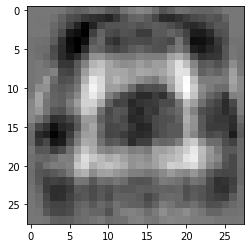

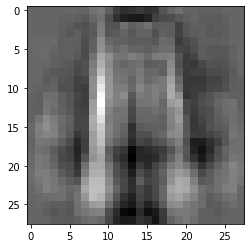

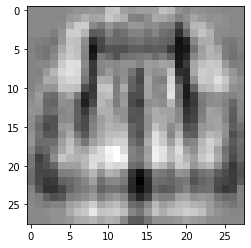

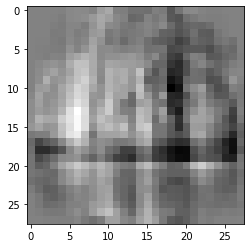

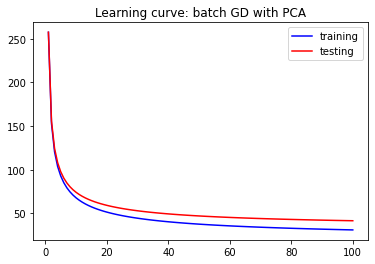

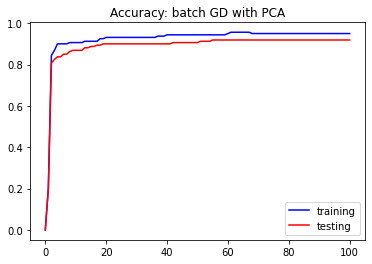

TYPE: batch GD
with PCA, d = 2
training accuracy	:  0.95
testing accuracy	:  0.91875


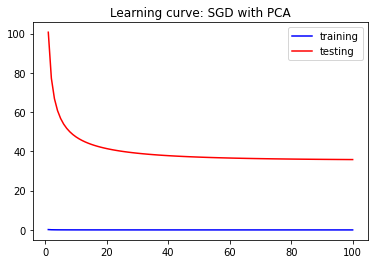

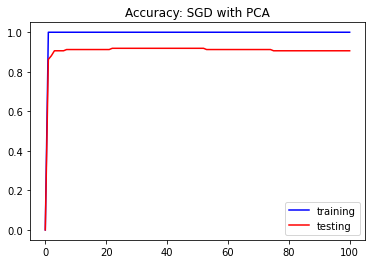

TYPE: SGD
with PCA, d = 2
training accuracy	:  1.0
testing accuracy	:  0.90625


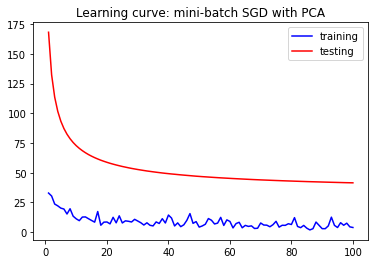

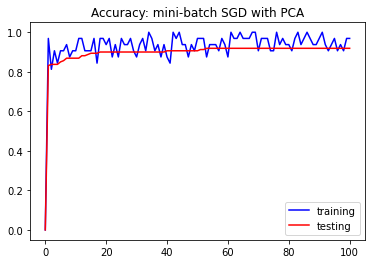

TYPE: mini-batch SGD
with PCA, d = 2
training accuracy	:  0.96875
testing accuracy	:  0.91875


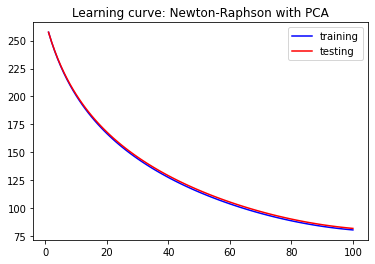

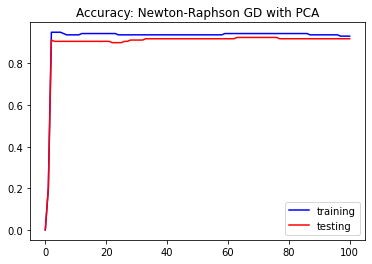

TYPE: Newton-Raphson GD
with PCA, d = 2
training accuracy	:  0.93125
testing accuracy	:  0.91875


In [15]:
eig, pca_x = PCA(x, 10)
#test_mean = np.mean(test_x, axis=0)
#test_x = test_x - test_mean
pca_testx = np.dot(test_x, eig)

PCA_show_eigen_vec(eig, 10)

ans = batch_GD(pca_x, t, pca_testx, test_t, 100, 0.001)
plt.plot(range(1,101), ans[0], '-b', label='training')
plt.plot(range(1,101), ans[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: batch GD with PCA')
plt.show()

plt.plot(range(0,101), ans[1], '-b', label='training')
plt.plot(range(0,101), ans[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: batch GD with PCA')
plt.show()

print("TYPE: batch GD")
print("with PCA, d = 2")
print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])

ans = SGD(pca_x, t, pca_testx, test_t, 100, 0.005)
plt.plot(range(1,101), ans[0], '-b', label='training')
plt.plot(range(1,101), ans[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: SGD with PCA')
plt.show()

plt.plot(range(0,101), ans[1], '-b', label='training')
plt.plot(range(0,101), ans[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: SGD with PCA')
plt.show()

print("TYPE: SGD")
print("with PCA, d = 2")
print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])

ans = minibatch_SGD(pca_x, t, pca_testx, test_t, 32, 100, 0.001)
plt.plot(range(1,101), ans[0], '-b', label='training')
plt.plot(range(1,101), ans[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: mini-batch SGD with PCA')
plt.show()

plt.plot(range(0,101), ans[1], '-b', label='training')
plt.plot(range(0,101), ans[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: mini-batch SGD with PCA')
plt.show()

print("TYPE: mini-batch SGD")
print("with PCA, d = 2")
print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])


ans = newton_raphson(pca_x, t, pca_testx, test_t, 100, 0.003)
plt.plot(range(1,101), ans[0], '-b', label='training')
plt.plot(range(1,101), ans[2], '-r', label='testing')
plt.legend()
plt.title('Learning curve: Newton-Raphson with PCA')
plt.show()

plt.plot(range(0,101), ans[1], '-b', label='training')
plt.plot(range(0,101), ans[3], '-r', label='testing')
plt.legend()
plt.title('Accuracy: Newton-Raphson GD with PCA')
plt.show()

print("TYPE: Newton-Raphson GD")
print("with PCA, d = 2")
print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])

## 3. Decision region

In [40]:
def basis(x, order):
  basis = x
  basis = np.concatenate( (np.ones([x.shape[0],1]), basis), axis=1 ).astype(float)
  for i in range(1, order):
    for j in list(combinations_with_replacement(range(1, 3), order)):
      y = np.prod(basis[:, j], axis=1).reshape((basis.shape[0], 1))
      basis = np.concatenate( (basis, y), axis=1 )
  return basis

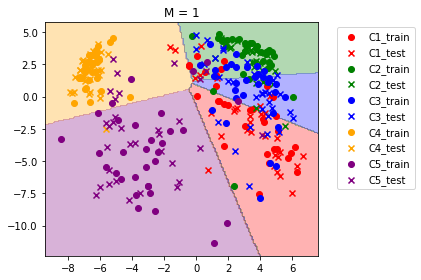

training accuracy	:  0.7625
testing accuracy	:  0.7375


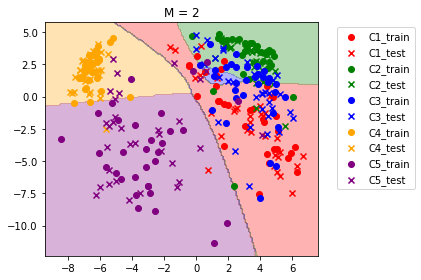

training accuracy	:  0.76875
testing accuracy	:  0.68125


In [42]:
eig, pca_x = PCA(x, 2)
b_1 = basis(pca_x, 1)
test_mean = np.mean(test_x, axis=0)
test_x = test_x - test_mean
pca_testx = np.dot(test_x, eig)
b_test_1 = basis(pca_testx, 1)

ans = batch_GD(b_1, t, b_test_1, test_t, 100, 0.001)

class_color = ['red', 'green', 'blue', 'orange', 'purple']
x_min, x_max = np.minimum(pca_x[:, 0].min(), pca_testx[:, 0].min()) - 1, np.maximum(pca_x[:, 0].max(), pca_testx[:, 0].max()) + 1
y_min, y_max = np.minimum(pca_x[:, 1].min(), pca_testx[:, 1].min()) - 1, np.maximum(pca_x[:, 1].max(), pca_testx[:, 1].max()) + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

b = np.dstack((xx, yy)).reshape(xx.shape[0]*xx.shape[1], 2)
z = np.dot(basis(b, 1), ans[4].transpose())
z = np.argmax(z, axis=1)
z = z.reshape(xx.shape)

cmap = matplotlib.colors.ListedColormap(class_color)
plt.contourf(xx, yy, z, cmap=cmap, levels=5, alpha=0.3)
plt.title("M = 1")
for i in range(5):
  plt.scatter(pca_x[i*32:(i+1)*32, 0], pca_x[i*32:(i+1)*32, 1], color=class_color[i], label='C'+str(i+1)+'_train')
  plt.scatter(pca_testx[i*32:(i+1)*32, 0], pca_testx[i*32:(i+1)*32, 1], color=class_color[i], label='C'+str(i+1)+'_test', marker='x')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])

b_2 = basis(pca_x, 2)
b_test_2 = basis(pca_testx, 2)
ans = batch_GD(b_2, t, b_test_2, test_t, 100, 0.001)

b = np.dstack((xx, yy)).reshape(xx.shape[0]*xx.shape[1], 2)
z = np.dot(basis(b, 2), ans[4].transpose())
z = np.argmax(z, axis=1)
z = z.reshape(xx.shape)

cmap = matplotlib.colors.ListedColormap(class_color)
plt.contourf(xx, yy, z, cmap=cmap, levels=5, alpha=0.3)
plt.title("M = 2")
for i in range(5):
  plt.scatter(pca_x[i*32:(i+1)*32, 0], pca_x[i*32:(i+1)*32, 1], color=class_color[i], label='C'+str(i+1)+'_train')
  plt.scatter(pca_testx[i*32:(i+1)*32, 0], pca_testx[i*32:(i+1)*32, 1], color=class_color[i], label='C'+str(i+1)+'_test', marker='x')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

print("training accuracy\t: ", ans[1][100])
print("testing accuracy\t: ", ans[3][100])